In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%pip install opencv-python
# Required to import cv2 !!!
import cv2

import os
import time

<h2> NMF-algoritmen </h2>
Under er en mal for hva en NMF funksjon burde ta inn og spytte ut. Merk at dere må fylle inn, akkurat nå kræsjer den.

From equations (15) and (16) in the project description we have that:

$
\\(H_{k+1})_{ij} \leftarrow (H_k)_{ij} \cdot \frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} \qquad(15)
\\(W_{k+1})_{ij} \leftarrow (W_k)_{ij} \cdot \frac{(A H_{k+1}^T)_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}} \qquad(16)
$

Which is non-negative for all $k$ if $A$ is as well, and $H_0$ and $W_0$ are positive, which follows from the definition of the matrix product:

$\\ (A B)_{ij} = \sum_{l=1}^{r} a_{il} b_{lj} $

Which results in a $m \times n $ matrix given that $dim(A)=m\times r, dim(B)=r\times n$, and for all the matrix products in (15) the resulting matrix will be non-negative at each element, which we can conclude from the definition of the matrix product, (15), and the definition of non-negativity, yielding:

$\\ \\(H_{k+1})_{ij} \leftarrow (H_k)_{ij} \cdot \Delta_{ij},\quad \Delta_{ij} \geq 0$
$\\(H_{k+1})_{ij} \geq 0,\quad (H_{k+1})_{ij} = 0 \Longleftrightarrow \sum_{l=1}^{r} (w_k)_{li} a_{lj}=0 \Longleftrightarrow A_{ij}=0 \enspace\forall i, A_j = 0$

Where $\Delta_{ij} = \frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}}$ not implying we do not use element-wise division. This is true for all elements and therefore $H$ is non-negative for all $k$ given that the initial $H$ and $W$ are positive.
By the exact same argument, but using $(16)$ instead of $(15)$ we get:

$\\(W_{k+1})_{ij} \geq 0, (W_{k+1})_{ij} = 0 \Longleftrightarrow \sum_{l=1}^{r} a_{il} (h_{k+1})_{jl}=0 \Longleftrightarrow A_{ij}=0 \enspace\forall j, A_i = 0$

If $WH=A$, we get that $\frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} = \frac{(W_k^T A)_{ij}}{(W_k^T A)_{ij}}=1 \enspace \forall i,j$ as we are dividing identical elements by each other. If $\Delta_{ij} = 1 \enspace\forall i,j \Rightarrow (H_{k+1})_{ij} = (H_{k})_{ij} \enspace\forall i,j, k$, and we have a fixed point. This is only true because $W_k$ also is a fixed point as we get $\frac{(A H_{k+1}^T)_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}} = \frac{(A H_{k+1}^T)_{ij}}{A H_{k+1}^T)_{ij}}$ and with the same argument as for $H_k$ we have that $W_k$ is a fixed point.

We only have an exception for $H_k$ (dividing by zero) if $A_{j}=0$, but then $(H_{k+1})_j=0 \enspace\forall k$ and then $H$ still is a fixed point, the error following from zero division is avoided with the safe division constant in the algorithm. We do not attempt a proof without this simplification for brevitys sake.

If we set either $H_0$ or $W_0$ to zero matrices we will divide by zero and get an error that way, and if we ignore this and set $\Delta_{ij}=1 \enspace\forall ij$ we will still be stuck with $H_k$ and $W_k$ equal to zero for ever and get no convergence.


In [27]:
def NMF(A, d, delta = 1.e-9, maxiter = 1000, seed = 0):
    """
    Takes in a matrix A and returns an NMF factorization and an array of the 
    Frobenius norm of the difference between A and the NMF.
    input:
        A: (m,n) input array
        d: integer, Number of components we want to decompose A into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        norms: (maxiter) array
    """
    
    m, n = np.shape(A)
    norms = np.zeros(maxiter)
    
    if seed != 0:
        np.random.seed(seed)
    
    W = np.random.uniform(0.0, 0.1, m*d).reshape((m,d))*np.sqrt(np.mean(A)/d)
    H = np.random.uniform(0.0, 0.1, d*n).reshape((d,n))*np.sqrt(np.mean(A)/d)
    
    for k in range(1,maxiter):
        H = np.multiply(H, np.divide(W.T@A,W.T@W@H+delta))
        W = np.multiply(W, np.divide(A@H.T,W@H@H.T+delta))
        norms[k] = np.linalg.norm(A-W@H,'fro')
    
    return W, H, norms

In [3]:
A1 = np.array([[1,0], 
               [0,1]], dtype='float')

A2 = np.array([[1,2], 
               [1,1],
               [1,2]], dtype='float')

A3 = np.array([[2,1,1], 
               [2,1,1],
               [1,1,2]], dtype='float')

A4 = np.array([[2,1,0], 
               [1,2,3],
               [0,3,3]], dtype='float')

In [4]:
print('NMF for A1 with d=1 for two random initializations:\n')
W1,H1,norm1 = NMF(A1, 1, maxiter = 10000, seed = 69420)
print(f'W:\n{W1}\n')
print(f'H:\n{H1}\n')
print(f'WH:\n{W1@H1}\n')
print(f'∥A−WH∥: {norm1[-1]}\n')

W1,H1,norm1 = NMF(A1, 1, maxiter = 10000)
print(f'W:\n{W1}\n')
print(f'H:\n{H1}\n')
print(f'WH:\n{W1@H1}\n')
print(f'∥A−WH∥: {norm1[-1]}\n')

print('NMF for A2 with d=1 for two random initializations:\n')
W2,H2,norm2 = NMF(A2, 1)
print(f'W:\n{W2}\n')
print(f'H:\n{H2}\n')
print(f'WH:\n{W2@H2}\n')
print(f'∥A−WH∥: {norm2[-1]}\n')

W2,H2,norm2 = NMF(A2, 1)
print(f'W:\n{W2}\n')
print(f'H:\n{H2}\n')
print(f'WH:\n{W2@H2}\n')
print(f'∥A−WH∥: {norm2[-1]}\n')

NMF for A1 with d=1 for two random initializations:

W:
[[0.0375676 ]
 [0.02523274]]

H:
[[18.34341356 12.32058138]]

WH:
[[0.68911795 0.46285462]
 [0.46285462 0.31088205]]

∥A−WH∥: 1.0

W:
[[0.03234397]
 [0.00098577]]

H:
[[30.88897558  0.94142801]]

WH:
[[9.99071966e-01 3.04495152e-02]
 [3.04495152e-02 9.28034225e-04]]

∥A−WH∥: 1.0

NMF for A2 with d=1 for two random initializations:

W:
[[0.09449438]
 [0.05767155]
 [0.09449438]]

H:
[[11.64349717 20.56463272]]

WH:
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

∥A−WH∥: 0.4111546000651087

W:
[[0.09904294]
 [0.06044762]
 [0.09904294]]

H:
[[11.10876847 19.62020003]]

WH:
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

∥A−WH∥: 0.4111546000651088



We see that the NMF for $A_1$ gives very different values for $WH$ while the (Frobenius) norm stays constant. For $A_2$ however, we see that two unique initialiations give two unique final values for $W$ and $H$, but that $WH$ stays the same and has converged to a certain value.

In [5]:
print('NMF for A1 with d=2')
W1,H1,norm1 = NMF(A1, 2)
print(f'W:\n{W1}\n')
print(f'H:\n{H1}\n')
print(f'WH:\n{W1@H1}\n')
print(f'∥A−WH∥: {norm1[-1]}\n')

print('NMF for A2 with d=2:\n')
W2,H2,norm2 = NMF(A2, 2, maxiter=10000)
print(f'W:\n{W2}\n')
print(f'H:\n{H2}\n')
print(f'WH:\n{W2@H2}\n')
print(f'∥A−WH∥: {norm2[-1]}\n')

NMF for A1 with d=2
W:
[[0.         0.03172188]
 [0.02815668 0.        ]]

H:
[[ 0.         35.51555243]
 [31.523981    0.        ]]

WH:
[[1. 0.]
 [0. 1.]]

∥A−WH∥: 4.241543419711833e-11

NMF for A2 with d=2:

W:
[[0.02537167 0.05621105]
 [0.00208942 0.07701815]
 [0.02537167 0.05621105]]

H:
[[11.32895029 53.26342824]
 [12.67661077 11.53897577]]

WH:
[[1. 2.]
 [1. 1.]
 [1. 2.]]

∥A−WH∥: 2.276633817844575e-09



In [6]:
"Fyll inn 1 f) og g) her!"

'Fyll inn 1 f) og g) her!'

With $d=2$ we get a NMF without removing values, and though there is no guarantee for a "perfect" NMF being possible, it is (as just demonstrated) possible for $A_1$ and $A_2$. From looking at $WH$ we conclude that we have a perfect decomposition and that the nonzero norm comes from floating point errors (notice that the norm for the bigger matrix is larger). This is reasonable as all matrices in task 1 are non-negative and with $d=2$ have a NMF of full rank, i.e. we do not lose any data points from dropping rows/columns and the only inaccuracies we get are from the discrepancies between the SVD and NMF. This happens because the SVD can always be perfect (with full rank), but it may have to assume negative values. Of course $d$ would have to be larger for matrices with larger rank.

<h2> Laste inn bilder </h2>
Vi begynner med å laste inn bildene. Mange måter å gjøre dette på, men dette er en av de enkleste. <b>Denne måten krever at du har en mappe som heter "imgs" som inneholder alle bildene i samme mappe som hvor du har denne notebooken (husk å unzippe filen). Bildene blir lagret i en (24, 24, 4, N) array som heter 'faces'</b> Man kan her også bestemme antall bilder man vil bruke $N$. Flere bilder betyr lengre kjøretid men bedre resultater. N = 500 virker til å være en god middle ground.

Slik koden er nå loader man alle 10 000 bildene og forkaster alle untatt $N$ bilder. Hvilke bilder som blir trekt ut er tilfeldig valgt med `np.random.choice`. I rapporten deres trenger ikke koden for å laste inn bilder se akkurat slik ut, men vi ønsker at alle grupper bruker forskjellige bilder, derfor gjør vi en tilfeldig sampling. 

In [7]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)


(24, 24, 4, 500)


In [8]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


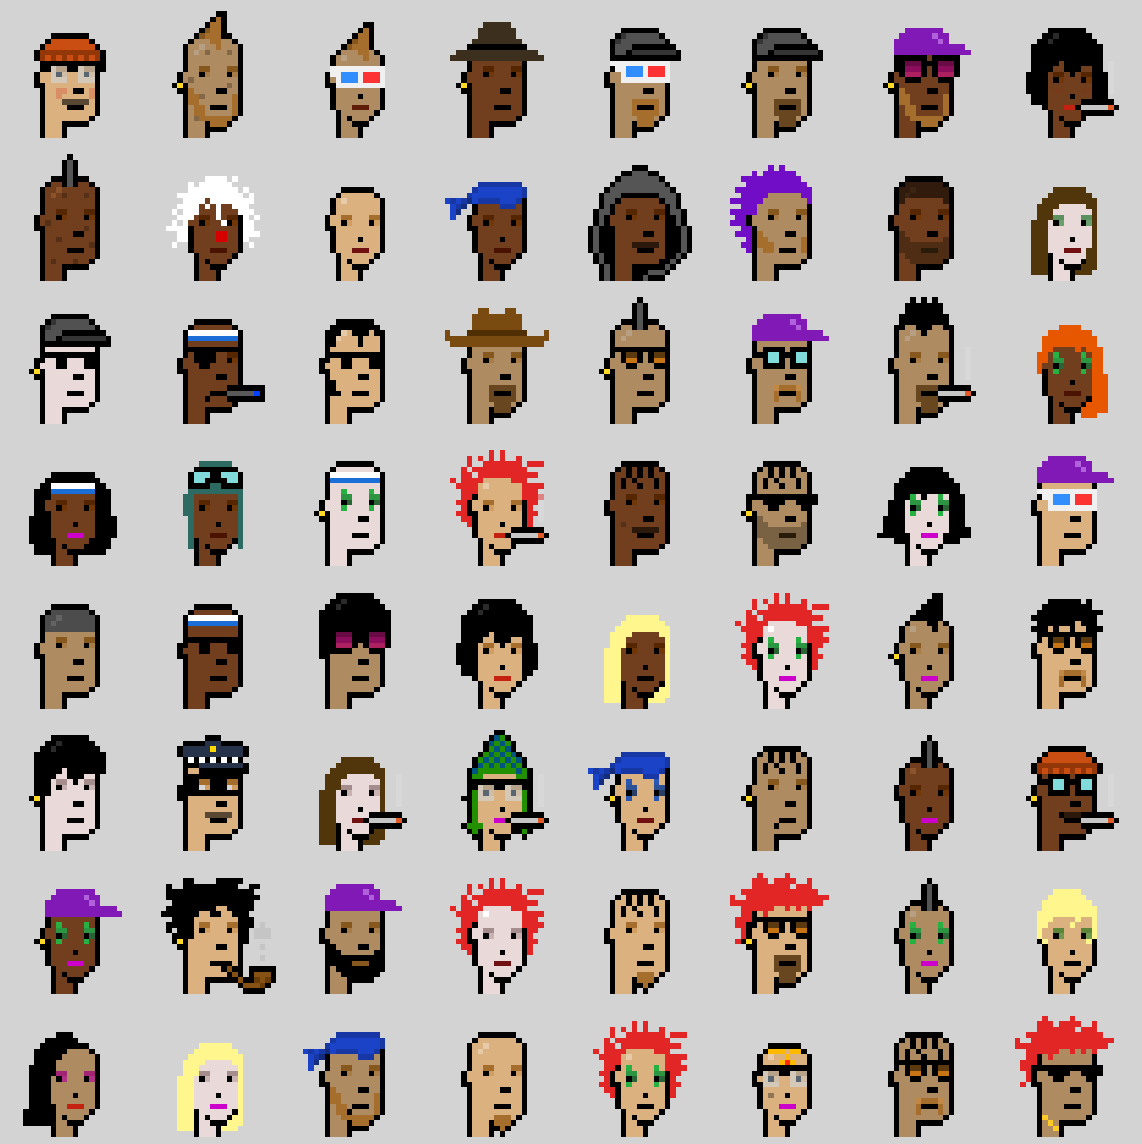

In [9]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

Under er noe dere egentlig kan gjøre dere vil, men her viser vi hvordan dere kan splitte fargekanalene fra opasitetskanalen, samt reshape slik at dere har en array som dere kan anvende NMF på. 

In [10]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)


In [11]:
print(np.shape(faces), '\n', np.shape(faces_rgb), '\n', np.shape(faces_opacity), '\n', np.shape(faces_reshaped))
print(np.shape(faces_rgb[0]))

(24, 24, 4, 500) 
 (24, 24, 3, 500) 
 (24, 24, 500) 
 (1728, 500)
(24, 3, 500)


In [51]:
dim = 8
W, H, _ = NMF(faces_reshaped, dim**2)
print(np.shape(W), '\n', np.shape(H))

(1728, 64) 
 (64, 500)


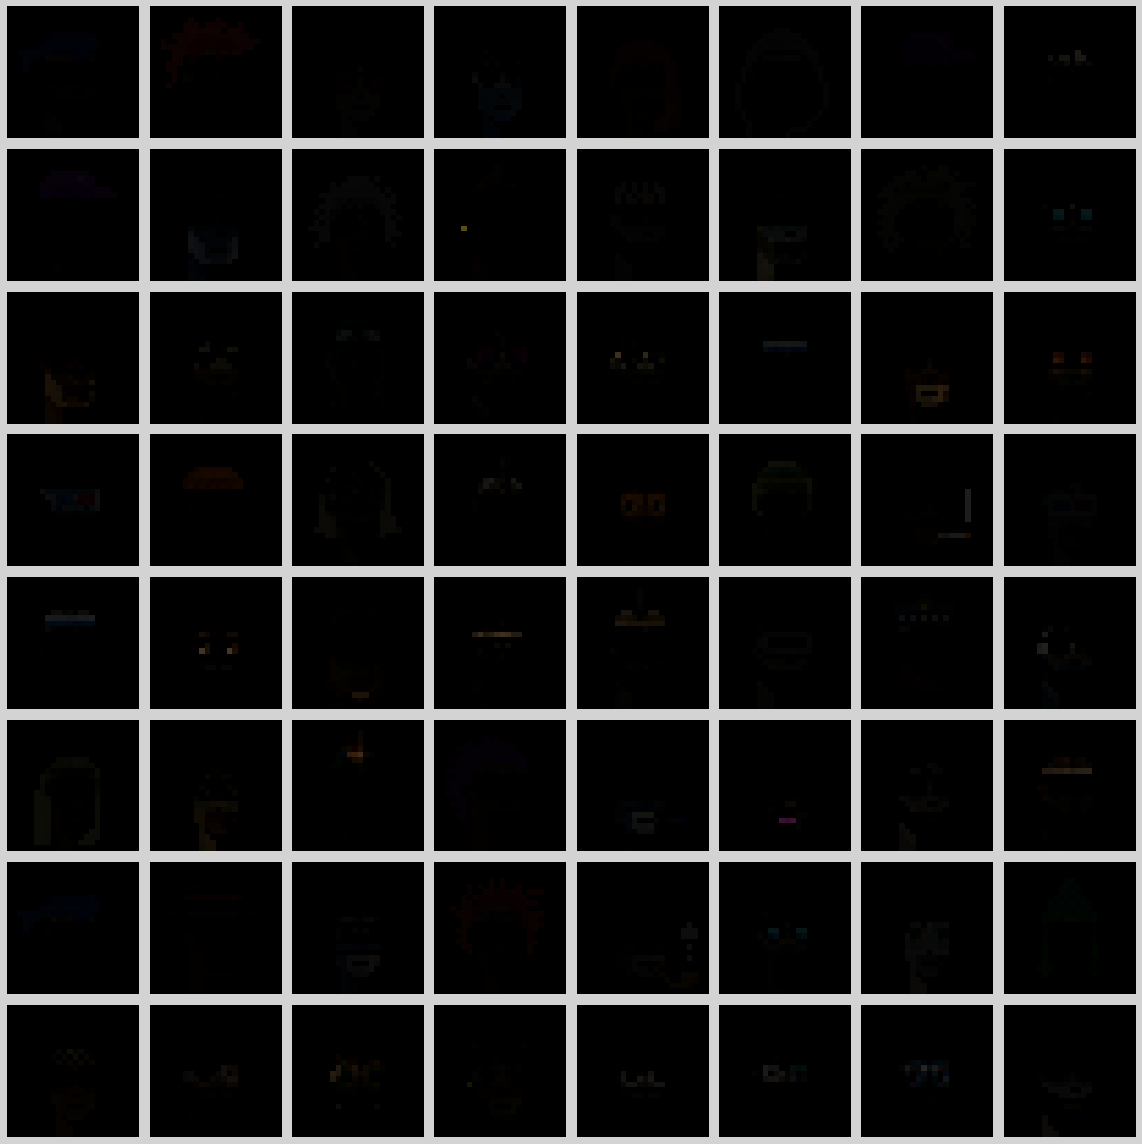

In [47]:
NMF_rgb = W.reshape((24, 24, 3, dim**2))
plotimgs(NMF_rgb,dim)

It is difficul to see because the images are rather dark, but we notice several features getting captured: Hats, hair styles, cigarettes, glasses, eyes, and beards among them. How well the NMF captured the features is easier to tell from the reconstruction which follows.

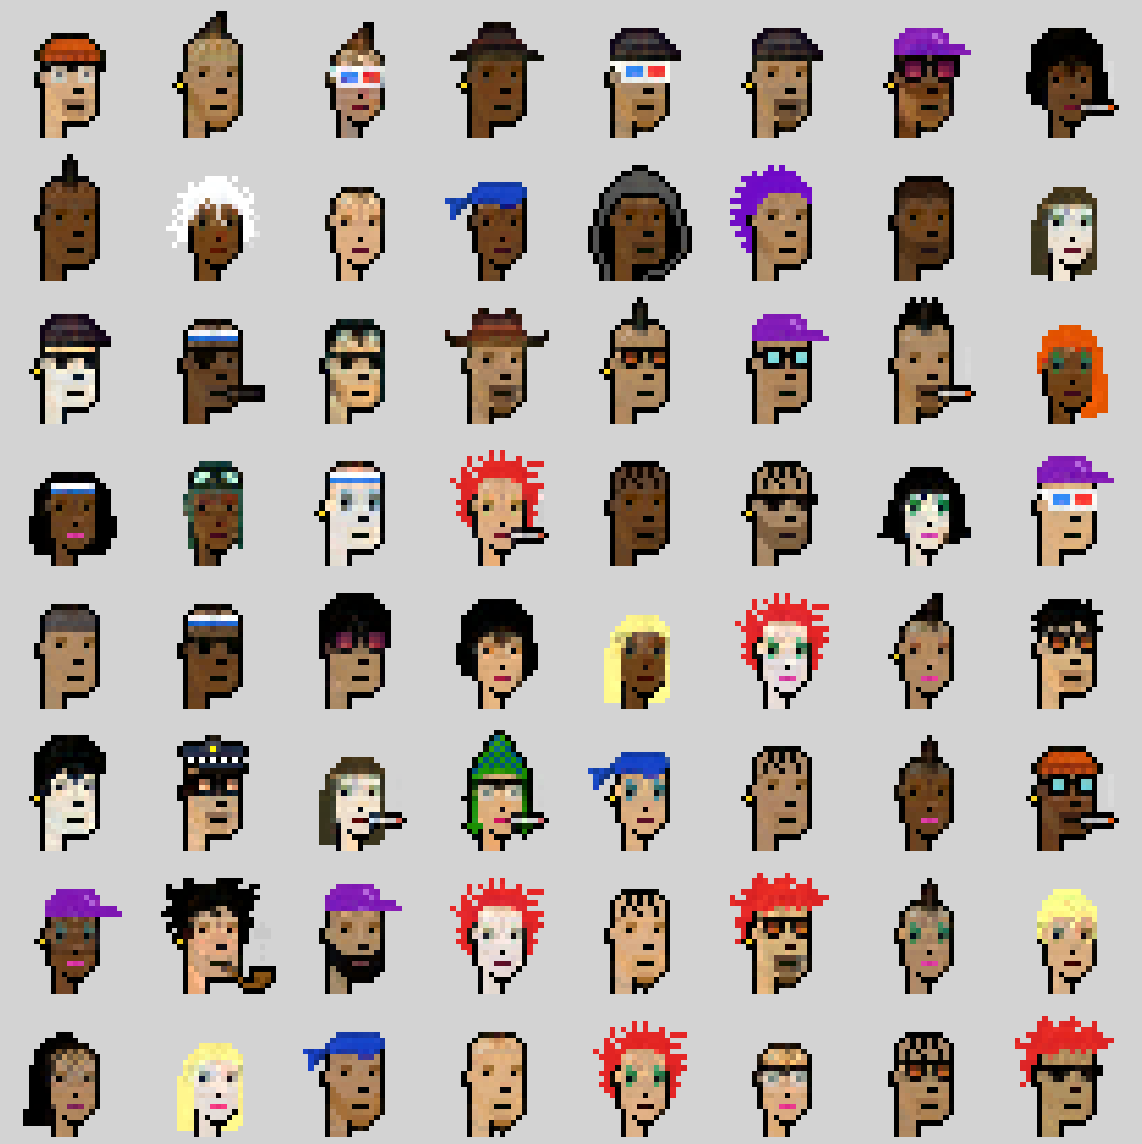

In [48]:
reconstruct = np.zeros(faces.shape)
reconstruct[:,:,:3,:] = (W@H).reshape(faces_rgb.shape)
for coord in np.argwhere(reconstruct>1):
    reconstruct[coord[0], coord[1], coord[2], coord[3]]=1
reconstruct[:,:,3,:] = faces_opacity
plotimgs(reconstruct, 8,)

Here we have the images reconstructed from the NMF factorization (d=64) with back-added opacity. We notice that the most striking features of the NFTs are quite clear, which implies the NMF captured them well. Notice especially the pipe (which is rare but still got captured, likely because the other images are empty there), hairstyles, hats, glasses, and the piercing. The NMF seems to have difficulties with most beards (except the black one) as the beard styles are often slightly pixelated. The skin color is usually quite good, but the faces are still, in some cases, very pixelated. To sum up it seems like the NMF works quite well with d=64, but it seems to struggle with the skin in the face and the mouth area. We have also tried this reconstruction with d=144 and the images were much clearer, the beard styles seem to have gotten captured at that level of detail and the faces are much more clear. In one iteration one NFT had a frown, and another had a cowboy hat. The cowboy hat was visible but miscolored, and the frown was non-existent at d=64, but at d=144 both became much clearer, though the frown was still somewhat unsharp. Whether the increase in computational time and data was worth it, however, is unclear, as the reconstruction with d=64 was already pretty good, and we had to double the detail and rows in the NMF, which also quadruples the flops needed to calculate the reconstruction, i.e. the matrix multiplication.

<h2> Legge til støy </h2>

Vi legger nå til støy i RGB kanalene slik det er forklart i oppgaveteksten

In [16]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces



Vi kan nå legge til støy til bildene våre, legge på opasitetskanalaen igjen og plotte. Dere må gjøre noe lignende etter dere har anvendt NMF og ønsker å plotte rekonstruksjoner med opasitet.

41.925268328812315


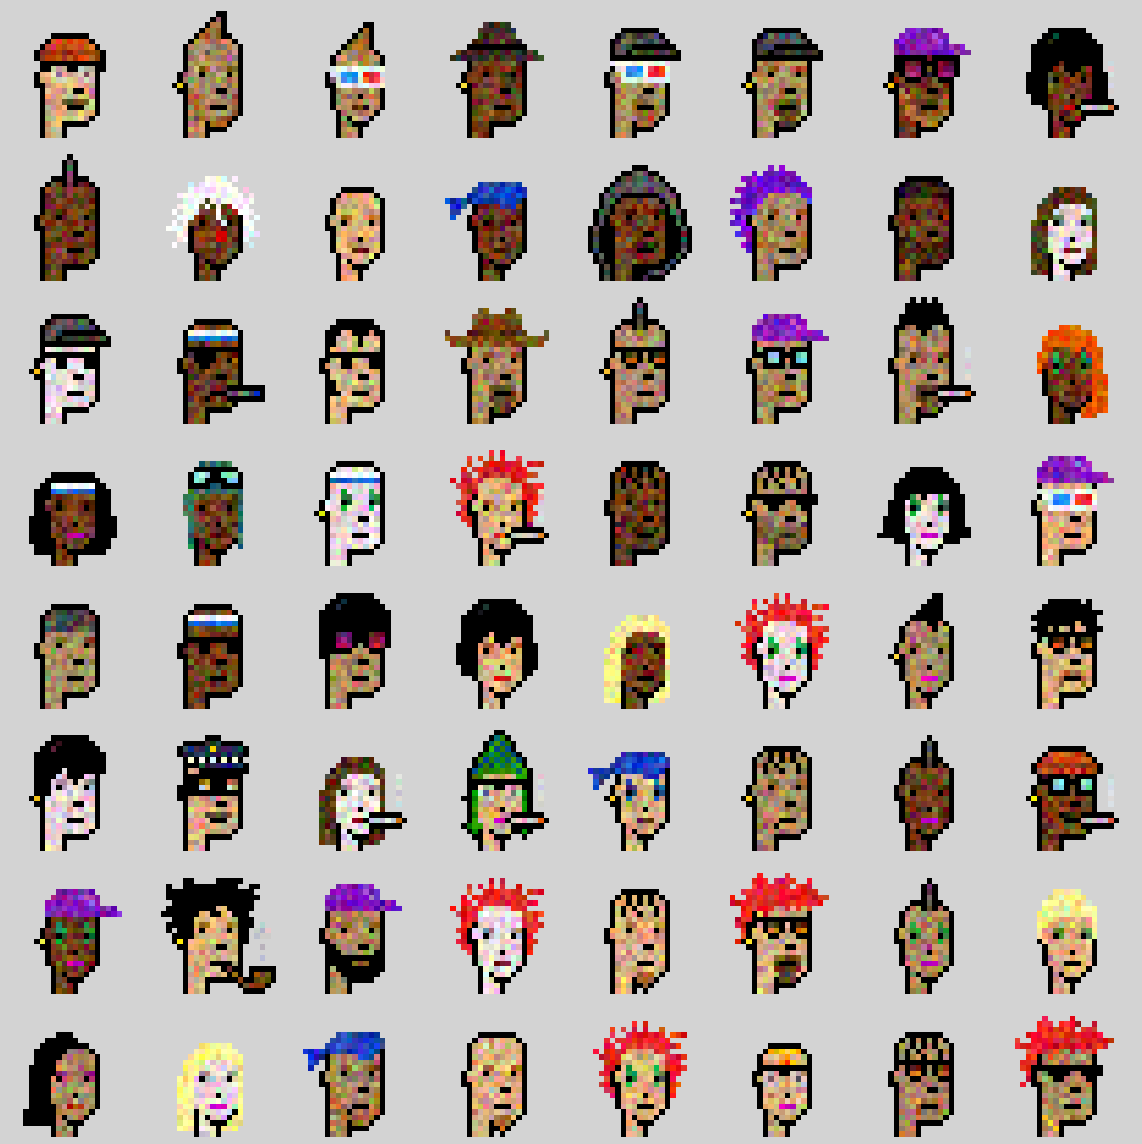

In [17]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)